# Задание № 5.3
# А/В-тесты изменения метрики линеаризованных лайков

In [97]:
# импортируем библиотеки
import pandahouse
from scipy import stats # Статистика
import seaborn as sns
import pingouin as pg

/nfs/env/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
/nfs/env/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.4.0, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


# Тест между 0 и 3 группами

In [10]:
# указываем параметры подключения к БД
connection = {
    'host': '',
    'password': '',
    'user': '',
    'database': ''
}

In [105]:
q_0_3 = """
SELECT 
    --посчитали метрику линеаризованных лайков
    exp_group,
    user_id,
    likes - ctr_control* views as linearized_likes
FROM 
(
SELECT DISTINCT exp_group,
    -- выбрали данные по 0 и 3 группам
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views
FROM {db}.feed_actions 
WHERE toDate(time) between '2023-05-01' and '2023-05-07'
        and exp_group in (0,3)
GROUP BY exp_group, user_id
) t1
CROSS JOIN
(SELECT DISTINCT 
    -- посчитали CTR в контрольной группе
    sum(action = 'like' and exp_group = 0)/sum(action = 'view' and exp_group = 0) as ctr_control
FROM {db}.feed_actions 
WHERE toDate(time) between '2023-05-01' and '2023-05-07') t2

"""

In [128]:
# выборка 0 и 3 группы, но в период проведения АА тестов.
q_0_3_2404_3004 = """
SELECT 
    --посчитали метрику линеаризованных лайков
    exp_group,
    user_id,
    likes - ctr_control* views as linearized_likes
FROM 
(
SELECT DISTINCT exp_group,
    -- выбрали данные по 0 и 3 группам
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views
FROM {db}.feed_actions 
WHERE toDate(time) between '2023-04-24' and '2023-04-30'
        and exp_group in (0,3)
GROUP BY exp_group, user_id
) t1
CROSS JOIN
(SELECT DISTINCT 
    -- посчитали CTR в контрольной группе
    sum(action = 'like' and exp_group = 0)/sum(action = 'view' and exp_group = 0) as ctr_control
FROM {db}.feed_actions 
WHERE toDate(time) between '2023-04-24' and '2023-04-30') t2

"""

In [111]:
q_1_2 = """
SELECT 
    --посчитали метрику линеаризованных лайков
    exp_group,
    user_id,
    likes - ctr_control* views as linearized_likes
FROM 
(
SELECT DISTINCT exp_group,
    -- выбрали данные по 1 и 2 группам
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views
FROM {db}.feed_actions 
WHERE toDate(time) between '2023-05-01' and '2023-05-07'
        and exp_group in (1,2)
GROUP BY exp_group, user_id
) t1
CROSS JOIN
(SELECT DISTINCT 
    -- посчитали CTR в контрольной группе
    sum(action = 'like' and exp_group = 1)/sum(action = 'view' and exp_group = 1) as ctr_control
FROM {db}.feed_actions 
WHERE toDate(time) between '2023-05-01' and '2023-05-07') t2

"""

In [106]:
# вызываем запрос и сохраняем в df полученные данные 0 и 3 групп
df = pandahouse.read_clickhouse(q_0_3, connection=connection)

In [129]:
# вызываем запрос и сохраняем в df полученные данные 0 и 3 групп в период 24.04-30.04.23
df_0_3_2404_3004 = pandahouse.read_clickhouse(q_0_3_2404_3004, connection=connection)

In [112]:
# вызываем запрос и сохраняем в df полученные данные 1 и 2 групп
df_1_2 = pandahouse.read_clickhouse(q_1_2, connection=connection)

# Первичная оценка данных (0, 3 группы)

In [ ]:
Для начала оценим на распределения метрики в группах визуально

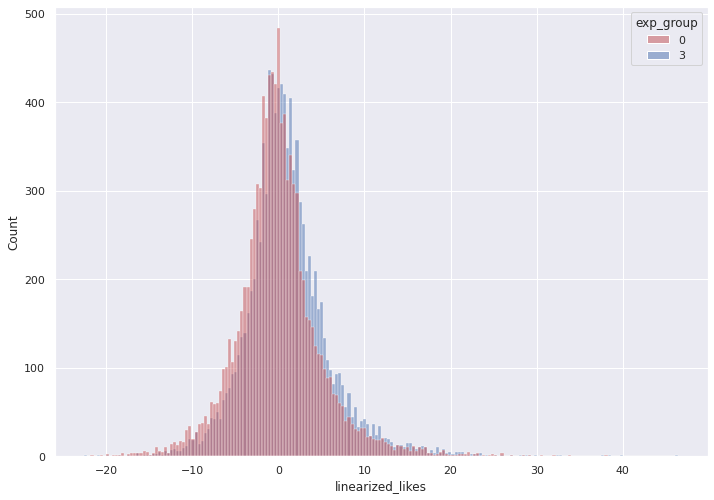

In [94]:
# увеличили размер графика
sns.set(rc={'figure.figsize':(11.7,8.27)})

groups = sns.histplot(data = df, 
              x='linearized_likes', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

В целом распределение очень похоже на нормальное. Распределение метрики визуально разница незначительно.

<AxesSubplot:xlabel='exp_group', ylabel='linearized_likes'>

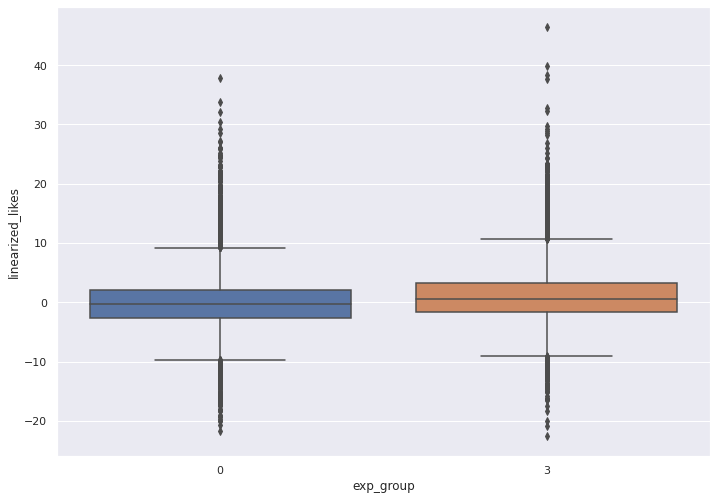

In [95]:
sns.boxplot(data=df, x="exp_group", y="linearized_likes")

Боксплот показывает, что медианное значение, 25-й и 75-й процентиль чуть выше в экспериментальной группе, а также в ней больше выбросов.

Ниже визуализация данных по 0 и 3 группам, но в период проведения АА тестов (24.04.23 - 30.04.23).

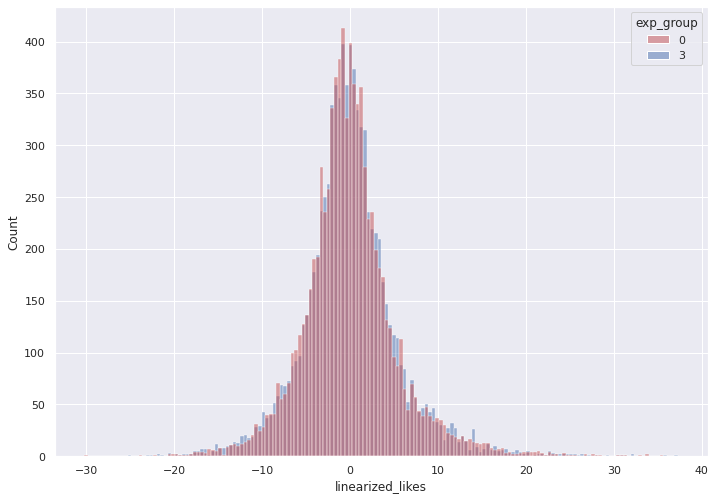

In [130]:
# увеличили размер графика
sns.set(rc={'figure.figsize':(11.7,8.27)})

groups = sns.histplot(data = df_0_3_2404_3004, 
              x='linearized_likes', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

<AxesSubplot:xlabel='exp_group', ylabel='linearized_likes'>

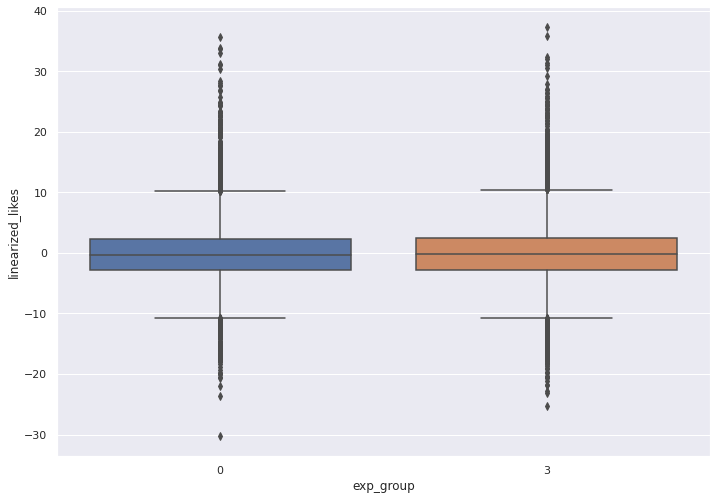

In [132]:
sns.boxplot(data=df_0_3_2404_3004, x="exp_group", y="linearized_likes")

Оба графика показали распределение метрик еще более схожее (визуально), чем за период проведения с 01.05 по 07.05.

# Метод Левена (0 и 3 группы)

Проверим являются ли дисперсии в генеральных совокупностях гомогенны. Для это используем метод Левена.
H0: дисперсии гомогенны
H1: дисперсии не являются гомогенными

In [99]:
pg.homoscedasticity(data=df, dv="linearized_likes", group="exp_group")

,W,pval,equal_var
levene,0.000025,0.996046,True


pvalue высокий, что подтверждает H0.

# Т-тест Стьюдента показателей линеаризованных лайков в группах (0, 3)

H0: показатели метрики стат.значимо не отличаются;
H1: показатели метрики стат.значимо отличаются.

In [104]:
# Запускаем ttest показателей линеаризованных лайков 0 и 3 групп
ttest = stats.ttest_ind(df[df.exp_group == 0].linearized_likes,
                df[df.exp_group == 3].linearized_likes,
                equal_var=False)
print(f'Значение статистики равно {ttest[0]}, показатель pvalue составляет {ttest[1]}')

Значение статистики равно -15.214995460903827, показатель pvalue составляет 5.4914249479690016e-52


Несмотря на в принципе очень похожие графики, ttest позволяет нам отвергнуть H0 и предположить, что значение целевой метрики в контрольной иэкспериментальной группах отличаются.

Для себя было решено проверить H0 и H1 гипотезы по 0 и 3 группам в период проведения АА теста (24.04.23 - 30.04.23)

In [133]:
# Запускаем ttest показателей линеаризованных лайков 0 и 3 групп
ttest = stats.ttest_ind(df_0_3_2404_3004[df_0_3_2404_3004.exp_group == 0].linearized_likes,
                df_0_3_2404_3004[df_0_3_2404_3004.exp_group == 3].linearized_likes,
                equal_var=False)
print(f'Значение статистики равно {ttest[0]}, показатель pvalue составляет {ttest[1]}')

Значение статистики равно -0.11789763322935291, показатель pvalue составляет 0.9061501573697005


Высокое значение pvalue не позволяет нам отклонить H0 гипотезу, что и хотелось подтвердить. Т.е. распределение метрик в контрольной и экспериментальной группах на момент проведения АА тестов стат.значимо не различаются.

# Первичная оценка данных (1, 2 группы)

Для начала оценим на распределения метрики в группах визуально

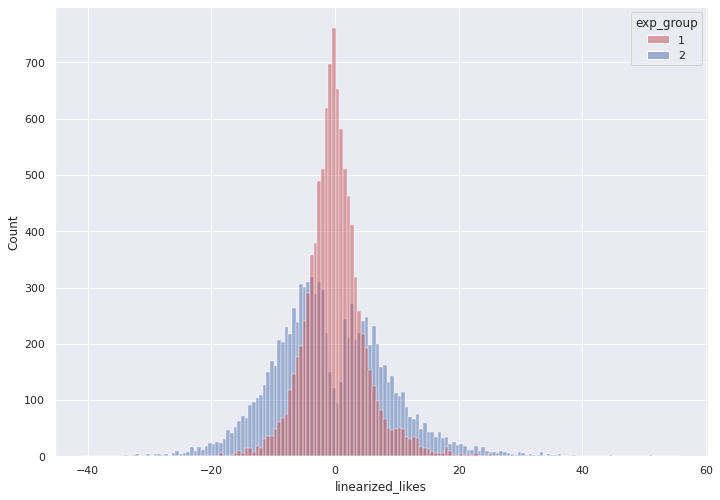

In [113]:
# увеличили размер графика
sns.set(rc={'figure.figsize':(11.7,8.27)})

groups = sns.histplot(data = df_1_2, 
              x='linearized_likes', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

Разница в графиках распределения целевой метрики визуально прослеживается. Распределение экспериментальной группы явно не похоже на нормальное.

<AxesSubplot:xlabel='exp_group', ylabel='linearized_likes'>

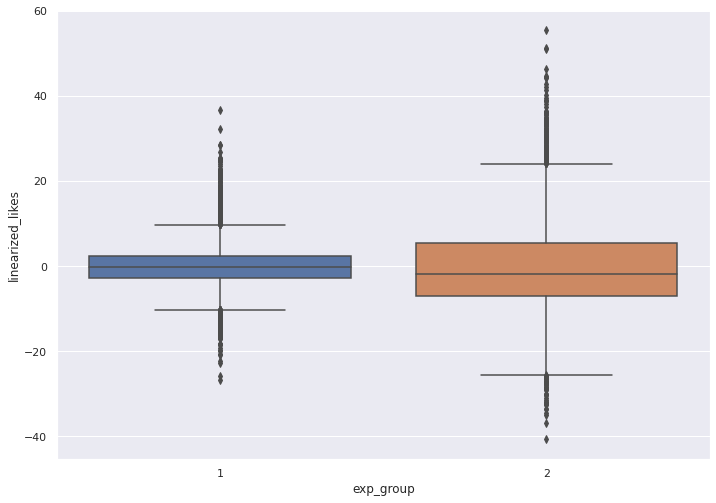

In [115]:
sns.boxplot(data=df_1_2, x="exp_group", y="linearized_likes")

Медианное значение распределения ctr и 25-й процентиль в контрольной группе выше, зато в эксперементальной группе выше 75-й процентиль. В целом видно, что разброс значений ctr в эксперементальной группе значительно выше. Но на основании полученных боксплотов затруднительно сделать какие-либо выводы.

# Метод Левена (проверка равенства дисперсий)

Проверим являются ли дисперсии в генеральных совокупностях гомогенны. Для это используем метод Левена.
H0: дисперсии гомогенны
H1: дисперсии не являются гомогенными

In [118]:
pg.homoscedasticity(data=df_1_2, dv="linearized_likes", group="exp_group")

,W,pval,equal_var
levene,3260.168567,0.0,False


H0 отвергаем, поскольку pvalue < 0.05. 

# Т-тест Стьюдента для показателей CTR в группах

Одним из условий получения достоверного результата с помощью ttest Стьюдента является равенство дисперсий. На предыдущем шаге мы выявили, что дисперсии не гомогенны. Так что в принцпипе этот расчет можно было бы пропустить, но мы все же посмотрим.

In [122]:
# Запускаем ttest ctr 1 и 2 групп
ttest = stats.ttest_ind(df_1_2[df_1_2.exp_group == 1].linearized_likes,
                df_1_2[df_1_2.exp_group == 2].linearized_likes,
                equal_var=False)
print(f'Значение статистики равно {ttest[0]}, показатель pvalue составляет {ttest[1]}')

Значение статистики равно 6.122579994775973, показатель pvalue составляет 9.439432187037712e-10


Несмотря на подтвержденное тестом Левена неравенство дисперсий. Показатель pvalue ниже порога 0.05, что позволяет нам отвергнуть H0. В то время как тот же тест по CTR выдавал абсолютно противоположный результат.

# Тест Манна-Уитни

Ради подтверждения эксперимента проведем тест Манна-Уитни.
H0: линеаризованные лайки в группах значимо не отличаются.
H1: линеаризованные лайки в группах значимо отличаются

In [125]:
mannwhitneyu = stats.mannwhitneyu(df_1_2[df_1_2.exp_group == 2].linearized_likes, 
                   df_1_2[df_1_2.exp_group == 1].linearized_likes, 
                   alternative = 'two-sided')
print(mannwhitneyu)

MannwhitneyuResult(statistic=45771671.0, pvalue=9.404319579641738e-27)


In [126]:
# разница pvalue Манна-Уитни и теста Стьюдента
print(mannwhitneyu[1] - ttest[1])

-9.439432187037712e-10


pvalue, полученный тестом Манна-Уитни, очень близок к pvalue, полученным ttest. Новая метрика кажется намного чувствительнее нежели ctr. Хотя я не могу сказать, что закрыла для себя вопрос: а можно ли использовать ttest при таком результате теста Левена даже на линеаризованную метрику.